Basket testing with layer1 coins, trading on btc

In [2]:
from dotenv import load_dotenv
from binance.client import Client as bnb_client
import os

load_dotenv()
# need TLD in US if US
client = bnb_client(tld='US', api_key=os.getenv('BINANCE_API'), api_secret=os.getenv('BINANCE_SECRET'))

In [3]:
all_binance_symbols =[symbol['symbol'] for symbol in client.get_exchange_info()['symbols']]
print(len(all_binance_symbols))

all_usdt_pairs = [symbol['symbol']  for symbol in client.get_exchange_info()['symbols'] if symbol['quoteAsset'] == 'USDT']
len(all_usdt_pairs)

547


176

In [4]:

import datetime
import pandas as pd 
import numpy as np 

def get_binance_px(symbol,freq,start_ts = '2020-01-01'):
    data = client.get_historical_klines(symbol,freq,start_ts)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
    'num_trades','taker_base_volume','taker_quote_volume','ignore']

    data = pd.DataFrame(data,columns = columns)
    
    # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
    data['open_time'] = data['open_time'].map(lambda x: datetime.datetime.fromtimestamp(x/1000, datetime.timezone.utc))
    data['close_time'] = data['close_time'].map(lambda x: datetime.datetime.fromtimestamp(x/1000, datetime.timezone.utc))
    return data 

univ = all_binance_symbols

freq = '1h'
filename = 'binance_{freq}_px.pkl'.format(freq=freq)
if filename not in os.listdir():
    px = {}
    for x in univ:
        data = get_binance_px(x,freq)
        px[x] = data.set_index('open_time')['close']

    px = pd.DataFrame(px).astype(float)
    px = px.reindex(pd.date_range(px.index[0],px.index[-1],freq=freq))
    px.to_pickle(filename)
else:
    px = pd.read_pickle(filename)
ret = px.pct_change()

C:\Users\joshu\AppData\Local\Temp\ipykernel_14060\366739778.py:32: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret = px.pct_change()


In [5]:
import requests

def get_layer1_coin_names():
    # Step 1: Define the API endpoint and parameters
    api_url = f'https://api.coingecko.com/api/v3/coins/markets?api_key={os.getenv('COINGECKO_API_KEY2')}'
    category = 'smart-contract-platform'  # Adjust based on actual category
    per_page = 250
    page = 1
    vs_currency = 'usd'
    order = 'market_cap_desc'
    sparkline = 'false'

    coin_names = []
    coin_ticker = []

    while True:
        params = {
            'vs_currency': vs_currency,
            'category': category,
            'order': order,
            'per_page': per_page,
            'page': page,
            'sparkline': sparkline
        }

        response = requests.get(api_url, params=params)

        if response.status_code != 200:
            print(f"Error: Unable to fetch data (Status Code: {response.status_code})")
            break

        data = response.json()

        if not data:
            # No more data to fetch
            break
        
        # Extract coin names
        for coin in data:
            coin_names.append(coin['name'])
            coin_ticker.append(coin['symbol'])

        print(f"Fetched page {page} with {len(data)} coins.")

        page += 1
    return coin_ticker

layer1_coins = get_layer1_coin_names()
print(f"\nTotal Layer 1 Coins Found: {len(layer1_coins)}")


Fetched page 1 with 250 coins.
Fetched page 2 with 250 coins.
Fetched page 3 with 213 coins.

Total Layer 1 Coins Found: 713


In [6]:
exchange_info = client.get_exchange_info()
binance_base_assets = [x['baseAsset'] for x in exchange_info['symbols']]

In [7]:
layer1_coin = [x.upper() for x in layer1_coins]
layer1_coin = [x for x in layer1_coin if x in binance_base_assets]
len(layer1_coin)

82

In [8]:
binance_layer1_symbols = [x['symbol'] for x in exchange_info['symbols'] if (x['baseAsset'] in layer1_coin and x['quoteAsset'] == 'USDT')]
layer1_binance_ret = ret[binance_layer1_symbols]

In [9]:
def compute_to_sharpe(weightings, ret):
    to = weightings.diff().abs().sum(1)
    port_ret = (weightings.shift(1) * ret).sum(1)
    bps = .0020
    port_ret = port_ret - bps * to
    print("Average Turnover: ", to.mean())
    print("Sharpe Ratio: ", np.sqrt(24*365) * port_ret.mean() / port_ret.std())
    port_ret.cumsum().plot()

    

Signal

Each hour, buy losing coins within the industry, and sell a basket of the most correlated in industry above 0.3 with equal weighting
or do the opposite

PARAMETERS:
 - number of coins to buy/sell without basket
 - buy winner or loser?
 - basket weighitngs/choosing parameters (what stocks, weightings of basket portfolio)
 - time horizon
 - when to trade

RESULTS:
- BASIC REVERSAL Buying/selling loser/winner in 1h time horizon: to - 0.5, sharpe: -3
- Buy loser sell 10 coins equal weighted that are most correlated with loser: to - 1.1, sharpe = -17 (basketn = 10, lookback = 24)
    - basketn = 5, lookback = 48: to - 1.3, sharpe = -17
    - basketn = 5, lookback = 72: to - 1.3, sharpe = -17


In [10]:
def rank_weighting(ret,lookback=60):
    '''rank weighting of returns in the lookback period'''
    ranked_ret = ret.rank(axis=1, pct=True)
    ranked_ret = ranked_ret.rolling(lookback).mean()
    return ranked_ret.div(ranked_ret.sum(axis=1),axis=0)

def reversal_weightings(ret):
    '''portfolio weightings based on signal weightings for reversal strategy'''
    # set max to -0.5 and min to 0.5
    def transform_row(row):
        max_val = row.max()
        min_val = row.min()
        return row.map(lambda x: -0.5 if x == max_val else (0.5 if x == min_val else 0))

    def long_short_basket(ret, lookback = 72, number_stock_basket = 10, buyorsell = 'buy'):
        '''long short basket of stocks based on correlation'''
        f = lambda x: x.idxmin()
        multiplier = 1
        if buyorsell == 'sell':
            f = lambda x: x.idxmax()
            multiplier = -1
        buysell_coin = ret.apply(f, axis = 1).dropna()
        
        rolling_corrs = ret.rolling(lookback)
        rolling_corrs = rolling_corrs.apply(lambda x: x.corr(x[buysell_coin[x.name]]))

        print(rolling_corrs)

    ret = long_short_basket(ret)
    return ret.apply(lambda x: x / x.abs().sum(), axis=1)


signal = reversal_weightings(layer1_binance_ret)

C:\Users\joshu\AppData\Local\Temp\ipykernel_14060\1154145462.py:17: FutureWarning: The behavior of Series.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  f = lambda x: x.idxmin()


KeyError: None

In [75]:
from numba import njit

def long_short_basket(ret, lookback = 24, number_stock_basket = 10, buyorsell = 'buy'):
    '''long short basket of stocks based on correlation'''
    multiplier = 1
    if buyorsell == 'buy':
        buysell_coin = ret.idxmin(axis=1)
    elif buyorsell == 'sell':
        buysell_coin = ret.idxmax(axis=1)
        multiplier = -1
    rolling_corrs = pd.DataFrame(index=ret.index, columns=ret.columns)
    rolling_ret = ret.rolling(window=lookback)

    @njit
    def compute_corr(window1, window2):
        # Remove NaNs
        mask = (~np.isnan(window1)) & (~np.isnan(window2))
        valid_window1 = window1[mask]
        valid_window2 = window2[mask]
        
        if len(valid_window1) < 2:
            return np.nan
        # Compute correlation
        mean1 = valid_window1.mean()
        mean2 = valid_window2.mean()
        std1 = valid_window1.std()
        std2 = valid_window2.std()
        if std1 == 0 or std2 == 0:
            return np.nan
        covariance = ((valid_window1 - mean1) * (valid_window2 - mean2)).sum()
        correlation = covariance / (len(valid_window1) * std1 * std2)
        return correlation
    
    # Step 4: Iterate Over Each Column and Compute Rolling Correlations
    for col in ret.columns:
        col_data = ret[col].values
        corr_values = np.full(len(ret), np.nan)
        
        for i in range(lookback - 1, len(ret)):
            current_time = ret.index[i]
            coin = buysell_coin.get(current_time, np.nan)
            if pd.isna(coin):
                continue
            coin_series = ret[coin].values
            # Define window indices
            window_start = i - lookback + 1
            window_end = i + 1
            window1 = col_data[window_start:window_end]
            window2 = coin_series[window_start:window_end]
            # Compute correlation
            corr = compute_corr(window1, window2)
            corr_values[i] = corr
        
        rolling_corrs[col] = corr_values
    
    def set_weights(row):
        coin = buysell_coin.loc[row.name]
        largest_indices = np.argpartition(-row.values, number_stock_basket+1)[:number_stock_basket + 1]
        mask = np.zeros(len(row), dtype=bool)
        mask[largest_indices] = True
        row[~mask] = 0
        row[mask] = -multiplier/2/number_stock_basket
        row[coin] = multiplier/2
        
        return row
    weights = rolling_corrs.apply(set_weights, axis=1)
    # def get_corr(x):
    #     coin = buysell_coin.loc[x.index[-1]]
    #     return x.corr(ret.loc[:,coin])
    # for col in ret.columns:
    #     rolling_corrs.loc[:,col] = rolling_corrs[col].rolling(lookback).apply(get_corr)
    return weights, rolling_corrs
temp = long_short_basket(layer1_binance_ret, lookback=72, number_stock_basket=5, buyorsell='sell')

C:\Users\joshu\AppData\Local\Temp\ipykernel_14060\3758503616.py:9: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  buysell_coin = ret.idxmax(axis=1)


In [68]:
temp[0].abs().sum(1).value_counts()

1.00    39602
1.00     3923
1.05      310
1.05       51
1.00       33
Name: count, dtype: int64

In [73]:
temp[1][sorted(temp[1].columns)]

,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ASTRUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BTCUSDT,...,VETUSDT,VITEUSDT,WAVESUSDT,WAXPUSDT,XECUSDT,XLMUSDT,XTZUSDT,ZECUSDT,ZENUSDT,ZILUSDT
2020-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 01:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 02:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 03:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 04:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-03 18:00:00+00:00,0.163779,0.062443,-0.038062,0.043065,-0.006936,0.070383,0.149957,-0.071141,0.058443,-0.196596,...,0.010950,-0.143506,NaN,-0.169508,-0.152628,-0.127044,-0.193736,-0.122657,0.113527,0.075156
2025-01-03 19:00:00+00:00,0.292406,0.070081,0.072256,0.245431,-0.012792,0.355471,0.052339,-0.020442,0.220143,-0.148531,...,0.450192,0.130742,NaN,-0.032400,0.123835,-0.071277,-0.118729,-0.046425,-0.125026,0.137534
2025-01-03 20:00:00+00:00,0.642775,-0.075606,-0.052348,0.043788,0.047378,0.708491,-0.121624,0.072368,0.333820,-0.351283,...,1.000000,0.027011,NaN,-0.010551,0.034852,0.328443,-0.165569,0.033754,-0.284966,-0.159634
2025-01-03 21:00:00+00:00,0.314274,0.082533,0.094955,0.231509,0.035538,0.367483,0.095341,0.005773,0.163754,-0.182873,...,0.449421,0.070024,NaN,-0.030155,0.087181,-0.061035,-0.112441,-0.051125,-0.157616,0.159845


Average Turnover:  1.247860834718459
Sharpe Ratio:  -44.78318207546031


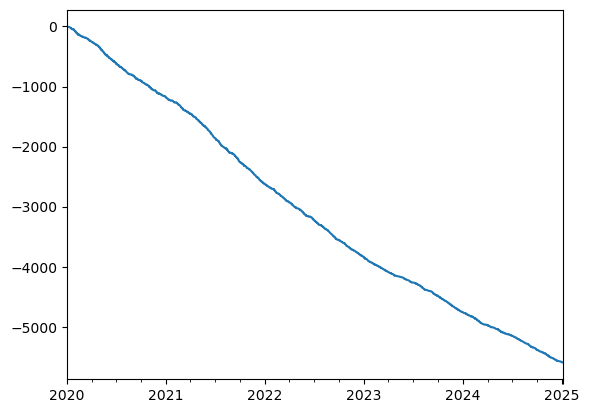

In [76]:
compute_to_sharpe(temp[0],layer1_binance_ret)

Average Turnover:  0.010277027145448286
Sharpe Ratio:  1.2108873381618122


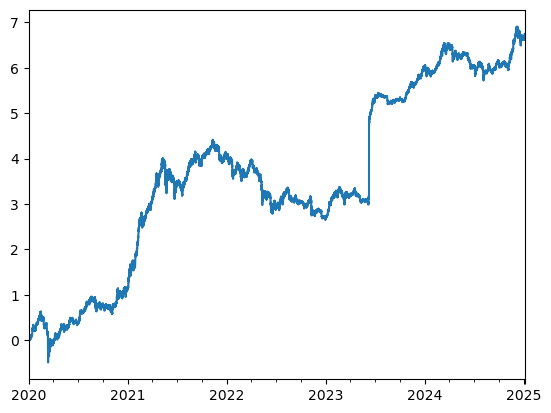

In [51]:
compute_to_sharpe(rank_weighting(layer1_binance_ret),layer1_binance_ret)